In [ ]:
!pip install pendulum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.9/384.9 kB 4.5 MB/s eta 0:00:00


#Import Libaries

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

import yfinance as yf
import pendulum

# Fetch stock data from yahoo

In [ ]:
# fetch history series
stock = 'IBM' # TSLA, AAPL, GOOG, META, MSFT, AMZN, DIS, IBM etc
# price_history = yf.Ticker(stock).history(period='10y', # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
#                                    interval='1d', # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
#                                    actions=False)
#price_history = yf.Ticker(stock).history(start="2012-11-30", end="2020-12-31", interval='1d', actions=False)
price_history = yf.Ticker(stock).history(start="2012-11-30", end="2022-12-02", interval='1d', actions=False)

train_portion = 0.75

In [ ]:
stocks = ['GOOG', 'AAPL', 'TSLA', 'META', 'MSFT', 'IBM']
prices = list()
for stock in stocks:
    p_1 = yf.Ticker(stock).history(start="2013-01-01", end="2022-12-31", interval='1d', actions=False)
    prices.append([p_1])

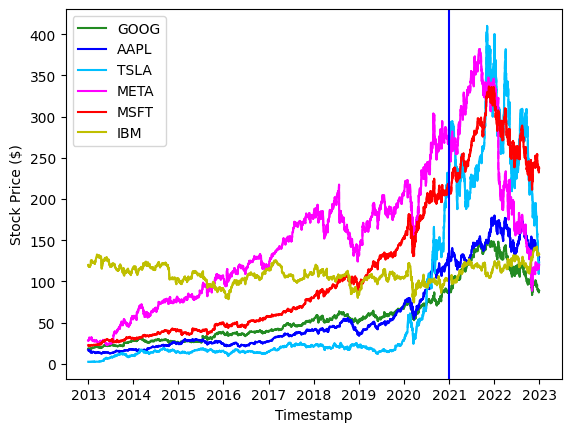

In [ ]:
colors = [
        'forestgreen',
        'b',
        'deepskyblue',
        'magenta',
        'r',
        'y'
    ]
for i in range(len(stocks)):
    plt.plot(prices[i][0]['Close'], linestyle='-', color=colors[i], label=stocks[i])
    plt.plot(prices[i][0]['Close'], linestyle='--', color=colors[i])
plt.legend()
plt.axvline(x=pd.Timestamp('2021-01-01'), color='b', linestyle='-')
plt.xlabel('Timestamp')
plt.ylabel('Stock Price ($)')
plt.show()

# Calculate Market Index

In [ ]:
pd.options.mode.chained_assignment = None

# Moving Average Convergence Divergence (MACD)
k = price_history['Close'].ewm(span=12, adjust=False, min_periods=12).mean()
d = price_history['Close'].ewm(span=26, adjust=False, min_periods=26).mean()
macd = k - d
price_history['macd'] = price_history.index.map(macd)

# Relative Strength Index (RSI)
window_length = 14
diff = price_history['Close'].diff(1)
gain = diff.clip(lower=0).round(2)
loss = diff.clip(upper=0).abs().round(2)
price_history['avg_gain'] = gain.rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
price_history['avg_loss'] = loss.rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
for i, row in enumerate(price_history['avg_gain'].iloc[window_length+1:]):
    price_history['avg_gain'].iloc[i + window_length + 1] = (price_history['avg_gain'].iloc[i + window_length] * (window_length - 1) + gain.iloc[i + window_length + 1]) / window_length
# Average Losses
for i, row in enumerate(price_history['avg_loss'].iloc[window_length+1:]):
    price_history['avg_loss'].iloc[i + window_length + 1] = (price_history['avg_loss'].iloc[i + window_length] * (window_length - 1) + loss.iloc[i + window_length + 1]) / window_length
rs = price_history['avg_gain'] / price_history['avg_loss']
price_history['rsi'] = 100 - (100 / (1.0 + rs))
price_history = price_history.drop('avg_gain', axis=1)
price_history = price_history.drop('avg_loss', axis=1)

# Commodity Channel Index (CCI)
tp = (price_history['High'] + price_history['Low'] + price_history['Close']) / 3
price_history['sma'] = tp.rolling(20).mean()
price_history['adv'] = tp.rolling(20).apply(lambda x: pd.Series(x).abs().mean())
price_history['cci'] = (tp - price_history['sma']) / (0.015 * price_history['adv'])
price_history = price_history.drop('sma', axis=1)
price_history = price_history.drop('adv', axis=1)

# Average Directional Index (ADX)
plus_dm = price_history['High'].diff()
minus_dm = price_history['Low'].diff()
plus_dm[plus_dm < 0] = 0
minus_dm[minus_dm > 0] = 0

tr1 = pd.DataFrame(price_history['High'] - price_history['Low'])
tr2 = pd.DataFrame(abs(price_history['High'] - price_history['Close'].shift(1)))
tr3 = pd.DataFrame(abs(price_history['Low'] - price_history['Close'].shift(1)))
frames = [tr1, tr2, tr3]
tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
atr = tr.rolling(14).mean()

plus_di = 100 * (plus_dm.ewm(alpha = 1/14).mean() / atr)
minus_di = abs(100 * (minus_dm.ewm(alpha = 1/14).mean() / atr))
dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
adx = ((dx.shift(1) * (14 - 1)) + dx) / 14
adx_smooth = adx.ewm(alpha = 1/14).mean()
price_history['adx'] = adx_smooth

price_history = price_history.dropna()

# Split the series into Train and Test


In [ ]:
time_series = price_history
print('length', len(time_series))
dt_list = [pendulum.parse(str(dt)).float_timestamp for dt in list(price_history.index)]

#Split into train, test
train_ind = int(len(time_series) * train_portion)

train_series = time_series[:train_ind]
test_series = time_series[train_ind:]

length 2494


# Markov Decision Process (MDP) environment declared here

In [ ]:
# Risk/Investment Management
balance_init = 1000 # initial balance in hand
k = 5 # max number of shares
min_balance = -100 # tolerance balance

# action
A = [a for a in range(-k, k+1, 1)]

# transition
def get_features(s, new_record):
    return list(new_record[5:])

def update_state(s, a, new_record):
    # s: (price, balance, shares)
    price, balance, shares = s[0], s[1], s[2]
    # a: (0 is hold, -k is sell, +k is buying)

    # Constraints
    # if is sell, check if there are enough number of shares
    if a < 0:
        if shares <= abs(a):
            a = -shares
    elif a > 0: # if buying, check if there are enough balance
        if balance - (a * price) < min_balance:
            possible_balance = np.array([balance - (a_ * price) for a_ in range(a)]) >= min_balance
            a = np.argmax(possible_balance)
    new_shares = shares + a
    new_balance = balance - (a * price)

    # apply fee (approx 0.1%)
    new_balance -= (a * price) * 1e-3

    # update state
    features = get_features(s, new_record)
    return [new_record['Close'], new_balance, new_shares] + features

# reward
def reward(s, s_next):
    return (s[1] + s[0]*s[2]) - (s_next[1] + s_next[0]*s_next[2])

# interact
def simulate(series, state_init, pi, greedy, eps=0.2):
    Rs = list()
    actions = list()
    states = [state_init]
    for index, row in series.iterrows():
        a = pi(states[-1], greedy=greedy, eps=eps)
        actions.append(a)
        states.append(update_state(states[-1], a, row))
        Rs.append(reward(states[-2], states[-1]))
    return states, Rs, actions

def interact_test(pi, series_name='test', verbose=True):
    if series_name == 'test':
        series = test_series
        prev_series = train_series
        prev_ind = -1
    elif series_name == 'train':
        series = train_series[1:]
        prev_series = train_series
        prev_ind = 0

    state_init = [prev_series['Close'][prev_ind], balance_init, 0] + list(prev_series.iloc[prev_ind][5:]) # price, balance, shares, Index

    # start a trajectory
    states, rewards, actions = simulate(series, state_init, pi, True)

    # verbose
    portforlio = np.array([s[1] + s[0]*s[2] for s in states])
    if verbose:
        print("Profit at The End of Trajactory:", portforlio[-1] - balance_init)

        plt.style.use('dark_background')
        plt.plot(series['Close'])
        plt.title("Price")
        plt.xlabel("Time (1 day inter val)")
        plt.ylabel("Price ($)")
        plt.show()

        plt.style.use('dark_background')
        plt.plot([s[2] for s in states])
        plt.title("Number of Shares")
        plt.xlabel("Time (1 day interval)")
        plt.ylabel("Num shares")
        plt.show()

        plt.style.use('dark_background')
        plt.plot(portforlio)
        plt.title("Portfolio ($)")
        plt.xlabel("Time (1 day inter val)")
        plt.ylabel("Portfolio ($)")
        plt.show()

        plt.style.use('dark_background')
        plt.plot(portforlio - balance_init)
        plt.title("Trading Profit")
        plt.xlabel("Time (1 day interval)")
        plt.ylabel("Profit ($)")
        plt.show()

    return portforlio[-1] - balance_init

#DataLoader

In [ ]:
class StatesDataset(Dataset):
    def __init__(self, states, rewards, actions):
        self.states = torch.Tensor(states[:-1]).float()
        self.states_next = torch.Tensor(states[1:]).float()
        self.rewards = torch.Tensor(rewards).float()
        self.actions = actions

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        return {
            'states': self.states[idx],
            'states_next': self.states_next[idx],
            'rewards': self.rewards[idx],
            'actions': self.actions[idx]
        }

#NN Structure required for Both Deep Q and Deep SARSA as they share the same NN structure


In [ ]:
class Qsa(nn.Module):
    def __init__(self, input_size=7, num_classes=len(A)):
        super().__init__()
        self.fc_liner = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
#             nn.Linear(32, 16),
#             nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.fc_liner(x)


def deep_q_learning(qsa,
                    series,
                    state_init,
                    pi,
                    optimizer,
                    loss_func,
                    epochs=10,
                    episode=100,
                    gamma=0.9,
                    lr=0.7,
                    eps=0.5,
                    min_eps=0.05,
                    decay=0.9,
                    greedy=False,
                    verbose=True,
                    sarsa=False
                   ):
    losses = list()
    learning_curve = list()
    # loop for each episode
    for epi in tqdm(range(episode)):
        # generate a trajectory
        eps *= decay
        states, rewards, actions = simulate(series, state_init, pi, greedy, eps=max(min_eps, eps))

        # form dataset and data loader
        dataset = StatesDataset(states, rewards, actions)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=False)

        # fit the deep NN
        for epo in range(epochs):
            for data_pack in dataloader:
                input_tensor = data_pack['states']
                out = qsa(input_tensor)
                output_tensor = out[[i for i in range(len(data_pack['rewards']))], [a+k for a in data_pack['actions']]]

                with torch.no_grad():
                    max_qsa_out = qsa(data_pack['states_next'])
                    if not sarsa:
                        max_qsa = max_qsa_out[[i for i in range(len(data_pack['rewards']))], max_qsa_out.argmax(dim=1)]
                        max_qsa = torch.Tensor(data_pack['rewards']).float() + (gamma * max_qsa)
                    else:
                        max_qsa = max_qsa_out[[i for i in range(len(data_pack['rewards']))], [a+k for a in data_pack['actions'][1:]] + [0]]
                    target_tensor = (1 - lr) * output_tensor + lr * max_qsa

                # update weights
                loss = loss_func(output_tensor, target_tensor)
                qsa.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().item())

        learning_curve.append(interact_test(pi, series_name='test', verbose=False))

    # verbose
    if verbose:
        print("Last loss", losses[-1])
        plt.plot(losses)
        plt.xlabel('Iterations (Not Epochs)')
        plt.ylabel('Loss')
        plt.savefig('loss.pdf')
        plt.show()
    return learning_curve

#Deep Q Learning Training

In [ ]:
def train_deep_q(verbose=False):
    qsa = Qsa(input_size=7, num_classes=len(A))
    state_init = [train_series['Close'][0], balance_init, 0] + list(train_series.iloc[0][5:])
    series = train_series[1:]

    optimizer = optim.Adam(
        qsa.parameters(),
        lr=1e-5, # 1e-4
    #     weight_decay=1e-6
    )
#     loss_func = nn.MSELoss()
    loss_func = nn.HuberLoss()

    def pi_deep(s, eps=0.2, greedy=False):
        with torch.no_grad():
            out_qsa = qsa(torch.Tensor(s).float()).squeeze()
            action = out_qsa.argmax().item() - k

            if not greedy:
                r = np.random.rand()
                # if it is on the less side, the explore other actions
                if r > 1 - eps + (eps / len(A)):
                    a_ = np.random.choice(A)
                    while a_ == action:
                        a_ = np.random.choice(A)
                    action = a_
        return action

    learning_curve = deep_q_learning(qsa,
                                     series,
                                     state_init,
                                     pi_deep,
                                     optimizer,
                                     loss_func,
                                     epochs=10, # number of epochs for training NN in each episode 10
                                     episode=30, # 30
                                     gamma=0.6, # discount coefficient 0.618
                                     lr=0.7, # learning rate for update q function
                                     eps=0.8, # eps greedy policy
                                     min_eps=0.2, # 0.2
                                     decay=0.9, # 0.9
                                     greedy=False,
                                     verbose=verbose
                                    )
    return pi_deep, qsa, learning_curve

In [ ]:
profits = list()
curves = list()
for i in range(20):
    pi_deep, qsa, learning_curve = train_deep_q(verbose=False)
    profits.append(interact_test(pi_deep, series_name='test', verbose=False))
    curves.append(learning_curve)
    print(i, 'Final Profit', profits[-1])
print('Avg profit', np.mean(profits))
print('STD profit', np.std(profits))

#Deep Sarsa Training

In [ ]:
def train_deep_sarsa(verbose=False, sarsa=False):
    qsa = Qsa(input_size=7, num_classes=len(A))
    state_init = [train_series['Close'][0], balance_init, 0] + list(train_series.iloc[0][5:])
    series = train_series[1:]

    optimizer = optim.Adam(
        qsa.parameters(),
        lr=1e-5, # 1e-4
    #     weight_decay=1e-6
    )
#     loss_func = nn.MSELoss()
    loss_func = nn.HuberLoss()

    def pi_deep(s, eps=0.2, greedy=False):
        with torch.no_grad():
            out_qsa = qsa(torch.Tensor(s).float()).squeeze()
            action = out_qsa.argmax().item() - k

            if not greedy:
                r = np.random.rand()
                # if it is on the less side, the explore other actions
                if r > 1 - eps + (eps / len(A)):
                    a_ = np.random.choice(A)
                    while a_ == action:
                        a_ = np.random.choice(A)
                    action = a_
        return action

    learning_curve = deep_q_learning(qsa,
                    series,
                    state_init,
                    pi_deep,
                    optimizer,
                    loss_func,
                    epochs=10, # number of epochs for training NN in each episode 10
                    episode=30, # 30
                    gamma=0.6, # discount coefficient 0.618
                    lr=0.7, # learning rate for update q function
                    eps=0.8, # eps greedy policy
                    min_eps=0.2, # 0.2
                    decay=0.9, # 0.9
                    greedy=False,
                    verbose=verbose,
                    sarsa=sarsa
                   )
    return pi_deep, qsa, learning_curve

In [ ]:
profits_sarsa = list()
for i in range(20):
    pi_deep_sarsa, qsa_sarsa, learning_curve = train_deep_sarsa(verbose=False, sarsa=True)
    profits_sarsa.append(interact_test(pi_deep_sarsa, series_name='test', verbose=False))
    curves.append(learning_curve)
    print(i, 'Final Profit', profits_sarsa[-1])
print('Avg profit', np.mean(profits_sarsa))
print('STD profit', np.std(profits_sarsa))

#Policy Gradient Training

In [ ]:
def simulate_pg(series, state_init, pi, greedy, eps=0.2):
    Rs = list()
    actions = list()
    state_init_norm = np.array(state_init)
    state_init_norm = (state_init_norm-min(state_init_norm)) / (max(state_init_norm) - min(state_init_norm))
    states = [state_init]

    states_normed = [list(state_init_norm)]

    for index, row in series.iterrows():
        a = pi(states_normed[-1], greedy=greedy, eps=eps)
        actions.append(a)
        s = update_state(states[-1], a, row)
        states.append(s)
        state = np.array(update_state(states[-1], a, row))
        state_norm = (state-min(state)) / (max(state)-min(state))
        states_normed.append(list(state_norm))
        Rs.append(reward(states[-2], states[-1]))
    return states_normed, Rs, actions


class Rpg(nn.Module):
    def __init__(self, input_size=7, num_classes=len(A)):
        super().__init__()
        self.fc_liner = nn.Sequential(
            nn.Linear(input_size, 20),
            nn.ReLU(),
            nn.Linear(20, num_classes),
            nn.Softmax(dim=-1)
        )


    def forward(self, x):
        return self.fc_liner(x)

In [ ]:
def pi_random(s, greedy=False, eps=0.2):
    return np.random.choice(A)


def policy_gradient_learning(rpg,
                    series,
                    state_init,
                    pi,
                    optimizer,
                    epochs=10,
                    episode=100,
                    gamma=0.9,
                    eps=0.5,
                    min_eps=0.05,
                    decay=0.9,
                    greedy=False,
                    verbose=True,
                    ):
    losses = list()

    profits_lc = list()
    # loop for each episode
    for epi in tqdm(range(episode)):
        # generate a trajectory
        eps *= decay
        if epi == 0:
            states, rewards, actions = simulate_pg(series, state_init, pi_random, greedy, eps=max(min_eps, eps))


        else:
            states, rewards, actions = simulate_pg(series, state_init, pi, greedy, eps=max(min_eps, eps))

        # form dataset and data loader
        dataset = StatesDataset(states, rewards, actions)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=False)
        # dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

        # fit the deep NN
        for epo in range(epochs):
            for data_pack in dataloader:
                input_tensor = data_pack['states']

                action_tensor = data_pack['actions']+k
                out = rpg(input_tensor)

                logprob = torch.log(out)

                action_tensor = torch.unsqueeze(action_tensor, 1)

                # Calculate the G_t at each t
                batch_reward = data_pack['rewards']
                discount_rewards = np.array([gamma** i * batch_reward[i] for i in range(len(batch_reward))])
                discount_rewards = discount_rewards[::-1].cumsum()[::-1]
                discount_rewards = torch.Tensor(discount_rewards.copy())



                # torch.gather() is used to calculate the log of pi(s_t, a_t)
                selected_logprobs = discount_rewards * torch.gather(logprob, 1, action_tensor).squeeze()
                loss = -selected_logprobs.mean()


                # update weights
                rpg.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().item())

        profits_lc.append(interact_test(pi, series_name='train', verbose=False))



    # verbose
    if verbose:
        print("Last loss", losses[-1])
        plt.plot(losses)
        plt.xlabel('Iterations (Not Epochs)')
        plt.ylabel('Loss')
        plt.show()

        plt.clf()
        plt.plot(profits_lc)
        plt.xlabel('Iterations (Not Epochs)')
        plt.ylabel('Profit')
        plt.show()

In [ ]:
def train_policy_gradient(verbose=False):
    rpg = Rpg(input_size=7, num_classes=len(A))
    state_init = [train_series['Close'][0], balance_init, 0] + list(train_series.iloc[0][5:])
    series = train_series[1:]

    optimizer = optim.SGD(rpg.parameters(), lr=1e-4)

    def pi_gradient(s, eps=0.2, greedy=False):
        with torch.no_grad():
            out_rpg = rpg(torch.Tensor(s).float()).squeeze()
            action = out_rpg.argmax().item() - k

            if not greedy:
                r = np.random.rand()
                # if it is on the less side, the explore other actions
                if r > 1 - eps + (eps / len(A)):
                    a_ = np.random.choice(A)
                    while a_ == action:
                        a_ = np.random.choice(A)
                    action = a_

        return action

    # Greedy is set to True in policy gradient.
    policy_gradient_learning(rpg,
                              series,
                              state_init,
                              pi_gradient,
                              optimizer,
                              epochs=10, # number of epochs for training NN in each episode 10
                              episode=30, # 30
                              gamma=0.6, # discount coefficient 0.618
                              eps=0.8, # eps greedy policy
                              min_eps=0.2, # 0.2
                              decay=0.9, # 0.9
                              greedy=False,
                              verbose=verbose
                            )
    return pi_gradient, rpg

In [ ]:
profits = list()
for i in range(20):
    pi_pg, rpg = train_policy_gradient(verbose=False)
    profits.append(interact_test(pi_pg, series_name='test', verbose=False))
    print(i, 'Final Profit', profits[-1])

print('Avg profit', np.mean(profits))
print('STD profit', np.std(profits))